<a href="https://colab.research.google.com/github/tomasmartins77/Machine_Learning_Lab/blob/main/pergunta2_parte2_CNN_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AAut Second problem part 2
## Image Segmentation

Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

Load data, normalize it and create train test data sets

In [4]:
# Load dataset
X_train = np.load('Xtrain2_b.npy')  # format b
y_train = np.load('Ytrain2_b.npy')  # segmentation masks

# Normalizing the input data
y_train = y_train / 255.0

# Reshaping the input data
X_train = X_train.reshape(-1, 48, 48)
y_train = y_train.reshape(-1, 48, 48)

# Categorize the labels
y_train = to_categorical(y_train, num_classes=2)


In [5]:
def augment_image(image, mask):
    augmented_images = []
    augmented_masks = []

    # Original image
    augmented_images.append(image)
    augmented_masks.append(mask)

    # Horizontal flip
    augmented_images.append(np.fliplr(image))
    augmented_masks.append(np.fliplr(mask))

    # Vertical flip
    augmented_images.append(np.flipud(image))
    augmented_masks.append(np.flipud(mask))

    # Rotate 90 degrees
    augmented_images.append(np.rot90(image, k=1))
    augmented_masks.append(np.rot90(mask, k=1))

    # Rotate 180 degrees
    augmented_images.append(np.rot90(image, k=2))
    augmented_masks.append(np.rot90(mask, k=2))

    # Rotate 270 degrees
    augmented_images.append(np.rot90(image, k=3))
    augmented_masks.append(np.rot90(mask, k=3))

    return augmented_images, augmented_masks

In [6]:
# Apply augmentation functions
augmented_X_train = []
augmented_y_train = []

for img, mask in zip(X_train, y_train):
    imgs, masks = augment_image(img, mask)
    augmented_X_train.extend(imgs)
    augmented_y_train.extend(masks)

# Convert lists to numpy arrays
augmented_X_train = np.array(augmented_X_train)
augmented_y_train = np.array(augmented_y_train)

# Shuffle the data
idx = np.random.permutation(len(augmented_X_train))
augmented_X_train = augmented_X_train[idx]
augmented_y_train = augmented_y_train[idx]

In [7]:
# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(augmented_X_train, augmented_y_train, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2625, 48, 48) (657, 48, 48) (2625, 48, 48, 2) (657, 48, 48, 2)


CNN model creation

In [8]:
# Define a CNN model for segmentation
def build_segmentation_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(48, 48, 1)))

    # Convolutional layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

    # Upsampling and Reconstruction layers for segmentation
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'))

    # Output layer (2 classes: crater or background)
    model.add(layers.Conv2D(2, (1, 1), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Train the model

Callbacks

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-5)

In [10]:
# Instantiate the model
model = build_segmentation_model()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.6711 - loss: 0.8104 - val_accuracy: 0.7409 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7517 - loss: 0.5262 - val_accuracy: 0.7668 - val_loss: 0.5138 - learning_rate: 0.0010
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7688 - loss: 0.5034 - val_accuracy: 0.7357 - val_loss: 0.5401 - learning_rate: 0.0010
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7896 - loss: 0.4750 - val_accuracy: 0.7862 - val_loss: 0.4718 - learning_rate: 0.0010
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8038 - loss: 0.4494 - val_accuracy: 0.8098 - val_loss: 0.4401 - learning_rate: 0.0010
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8138 - loss: 0.4307 - val_accuracy: 0.7955 - val_loss: 0.4943 - learning_rate: 0.0010
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8216 - loss: 0.4201 - val_a

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
(657, 48, 48, 2) (657, 48, 48, 2)
Balanced accuracy: 0.7320796631111266


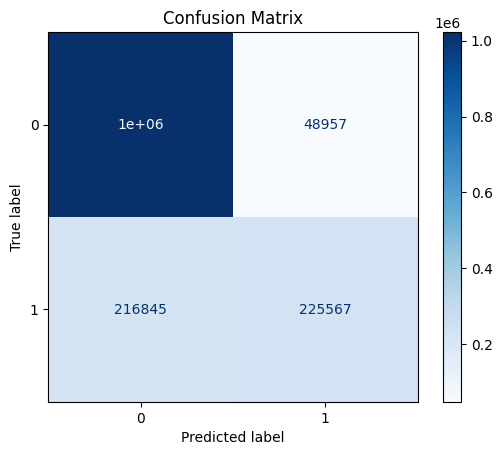

In [11]:

y_pred = model.predict(X_val)
y_pred_final = np.argmax(y_pred, axis=-1)
y_val_final = np.argmax(y_val, axis=-1)
print(y_pred.shape, y_val.shape)

print('Balanced accuracy:', balanced_accuracy_score(y_val_final.flatten(), y_pred_final.flatten()))

# Confusion matrix
cm = confusion_matrix(y_val_final.flatten(), y_pred_final.flatten())

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()